# Predicting Genetic Biomarker in Brain Tumor.Pl predict the genetic subtype of glioblastoma using MRI (magnetic resonance imaging) scans to train and test your model to detect for the presence of MGMT promoter methylation* Glossary 
ssary
MGMT promoter methylation - The presence of a specific genetic sequence in the tumor known as MGMT promoter methylation has been shown to be a favorable predictive factor and a strong predictor of responsiveness to chemotherapy.
Radio genomics - the field of predicting the genetics of the cancer through 
imaging
Types of mpMRI
* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)
eighted (T2)

# Packages:

In [1]:
import os
import re 
import glob
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Pydicom related imports
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import SimpleITK as sitk

# Deep learning packages
import tensorflow as tf

# For gif creation
import imageio

import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Inspection
Definition: Loading data into a DataFrame and inspecting it is the first step in EDA. This allows you to understand the structure, column names, and sample values within the dataset.

In [2]:
import pandas as pd

# Load data
train_df = pd.read_csv(r'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

# Inspect the data
print(train_df.head())
print(train_df.info())
print(train_df.describe())


   BraTS21ID  MGMT_value
0          0           1
1          2           1
2          3           0
3          5           1
4          6           1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   BraTS21ID   585 non-null    int64
 1   MGMT_value  585 non-null    int64
dtypes: int64(2)
memory usage: 9.3 KB
None
         BraTS21ID  MGMT_value
count   585.000000  585.000000
mean    431.179487    0.524786
std     251.545000    0.499813
min       0.000000    0.000000
25%     219.000000    0.000000
50%     423.000000    1.000000
75%     630.000000    1.000000
max    1010.000000    1.000000


# 2. Checking Class Distribution
Definition: It's essential to understand the distribution of the target variable (in this case, the MGMT promoter methylation status). This helps you assess any class imbalance.

In [3]:
# Check distribution of MGMT promoter methylation status
print(train_df['MGMT_value'].value_counts())


1    307
0    278
Name: MGMT_value, dtype: int64


In [4]:
df_train_labels = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
df_train_labels = df_train_labels.rename(columns={'BraTS21ID': 'PatientId'})
df_train_labels['PatientId'] = [format(x, '05d') for x in df_train_labels.PatientId]
df_train_labels['PatientId'] = df_train_labels['PatientId'].astype(str)
df_train_labels.describe()

,MGMT_value
count,585.000000
mean,0.524786
std,0.499813
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
patients = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/*')
print(f'There are {len(patients)} patients in the training data')

There are 585 patients in the training data


In [6]:
patients = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/*')
print(f'There are {len(patients)} patients in the test data')

There are 87 patients in the test data


In [7]:
train_files = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/*/*/*')
print(f'There are {len(train_files)} dicom files in the training data')

There are 348641 dicom files in the training data


In [8]:
test_files = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/*/*/*')
print(f'There are {len(test_files)} dicom files in the test data')

There are 51473 dicom files in the test data


In [9]:
# Define keys for scan types
keys = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

# Number of files per patient per Key.
train_folders = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'
df_patient_records_train = pd.DataFrame(columns=['PatientId'] + keys)
df_patient_records_train.set_index('PatientId')
for f in tqdm(os.listdir(train_folders)):
    patientId = f
    df_patient_records_train = df_patient_records_train.append({'PatientId': patientId, 'FLAIR': 0, 'T1w': 0, 'T1wCE': 0, 'T2w' : 0}, ignore_index=True)
    for key in keys:
        patientId_key_path = f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patientId}/{key}/*.dcm'
        df_patient_records_train.loc[df_patient_records_train['PatientId'] == patientId, [key]] = len(glob.glob(patientId_key_path))
df_patient_records_train.head()

100%|██████████| 585/585 [00:08<00:00, 72.93it/s]


,PatientId,FLAIR,T1w,T1wCE,T2w
0,00688,196,214,214,376
1,00058,257,29,120,384
2,00516,196,32,222,416
3,00185,60,192,192,64
4,00547,216,352,129,129


In [10]:
# Number of files per patient per Key.
test_folders = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/'
df_patient_records_test = pd.DataFrame(columns=['PatientId'] + keys)
df_patient_records_test.set_index('PatientId')
for f in tqdm(os.listdir(test_folders)):
    patientId = f
    df_patient_records_test = df_patient_records_test.append({'PatientId': patientId, 'FLAIR': 0, 'T1w': 0, 'T1wCE': 0, 'T2w' : 0}, ignore_index=True)
    for key in keys:
        patientId_key_path = f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/{patientId}/{key}/*.dcm'
        df_patient_records_test.loc[df_patient_records_test['PatientId'] == patientId, [key]] = len(glob.glob(patientId_key_path))
df_patient_records_test.head()

100%|██████████| 87/87 [00:01<00:00, 80.22it/s]


,PatientId,FLAIR,T1w,T1wCE,T2w
0,00114,20,20,192,20
1,00013,129,30,129,408
2,00821,27,27,27,27
3,00644,216,202,202,432
4,00699,190,95,228,400


In [11]:
for key in keys:
    df_patient_records_train[key] = df_patient_records_train[key].astype(int)
df_patient_records_train['PatientId'] = df_patient_records_train['PatientId'].astype(str)
df_patient_records_train["TotalFiles"] = df_patient_records_train[keys].sum(axis=1)
assert df_patient_records_train.TotalFiles.sum() == len(train_files)
df_patient_records_train.head()

,PatientId,FLAIR,T1w,T1wCE,T2w,TotalFiles
0,00688,196,214,214,376,1000
1,00058,257,29,120,384,790
2,00516,196,32,222,416,866
3,00185,60,192,192,64,508
4,00547,216,352,129,129,826


In [12]:
for key in keys:
    df_patient_records_test[key] = df_patient_records_test[key].astype(int)
df_patient_records_test['PatientId'] = df_patient_records_test['PatientId'].astype(str)
df_patient_records_test["TotalFiles"] = df_patient_records_test[keys].sum(axis=1)
assert df_patient_records_test.TotalFiles.sum() == len(test_files)
df_patient_records_test.head()

,PatientId,FLAIR,T1w,T1wCE,T2w,TotalFiles
0,00114,20,20,192,20,252
1,00013,129,30,129,408,696
2,00821,27,27,27,27,108
3,00644,216,202,202,432,1052
4,00699,190,95,228,400,913


100%|██████████| 348641/348641 [00:00<00:00, 999161.17it/s] 


<AxesSubplot:>

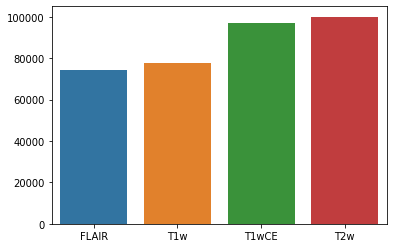

In [13]:
keys = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

label_dict = {
    'FLAIR': [],
    'T1w': [],
    'T1wCE': [],
    'T2w': []
}

label_dict_counts = {}

for filename in tqdm(train_files):
    
    scan = filename.split('/')[-2]
    
    if scan=='FLAIR':
        label_dict['FLAIR'].append(filename)
        
    elif scan=='T1w':
        label_dict['T1w'].append(filename)

    elif scan=='T1wCE':
        label_dict['T1wCE'].append(filename)

    else:
        label_dict['T2w'].append(filename)
    
for key in keys:
    label_dict_counts[key] = len(label_dict[key])

values = label_dict_counts.values()
sns.barplot(x=keys, y=list(values))

# 3. Loading and Preprocessing MRI Images
Definition: MRI images are often stored in DICOM format. You’ll need to load and preprocess these images (e.g., resizing, normalization) to make them suitable for model training.

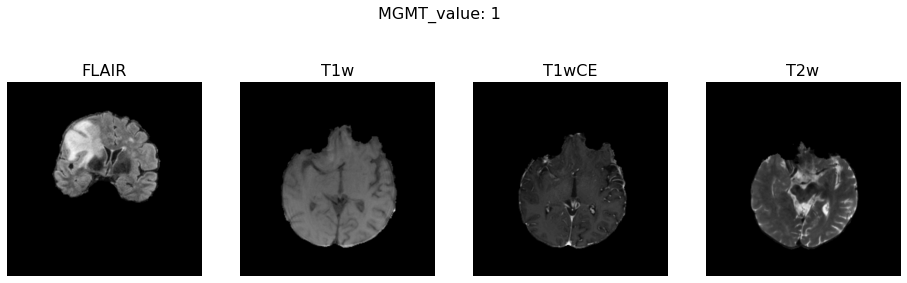

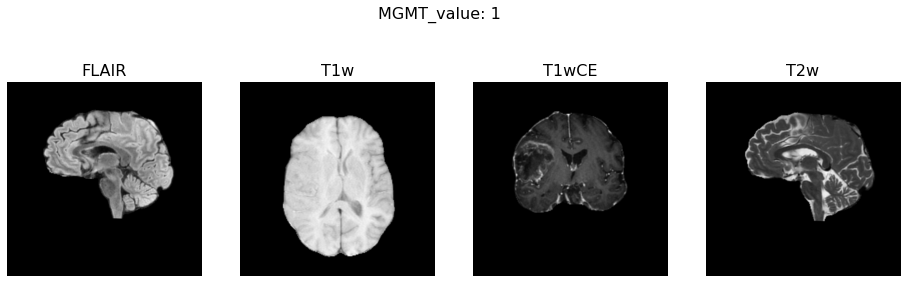

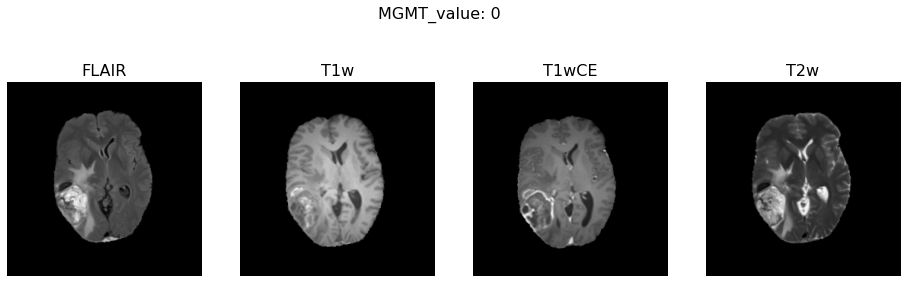

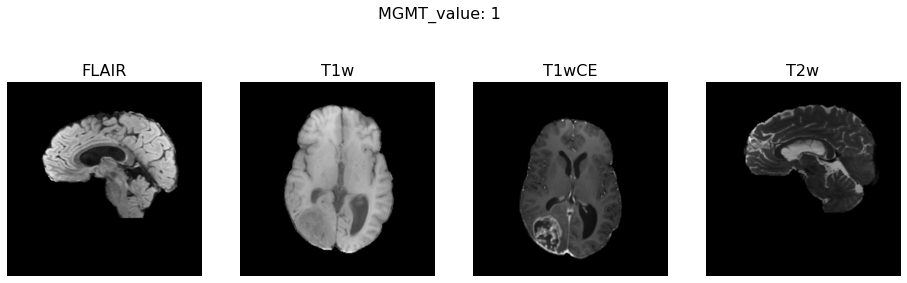

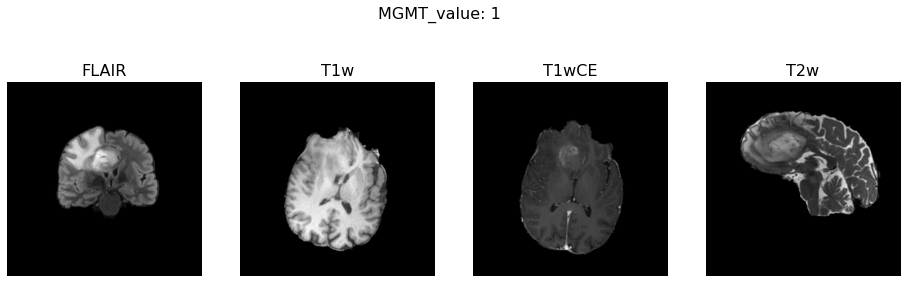

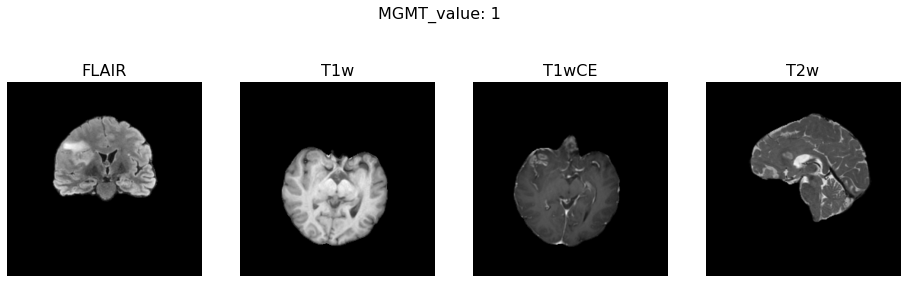

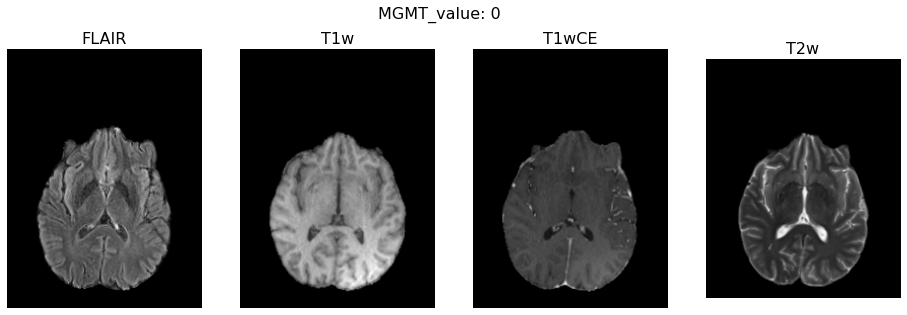

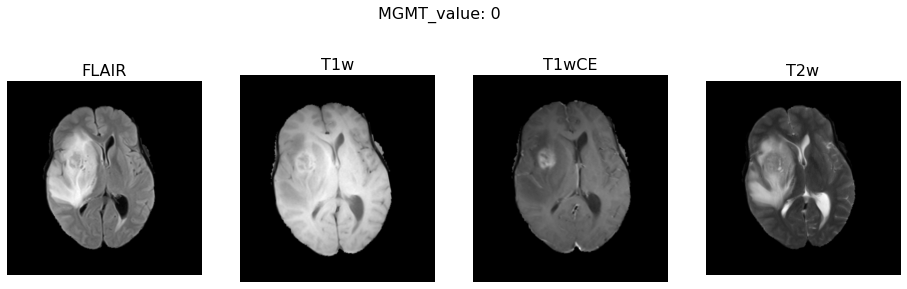

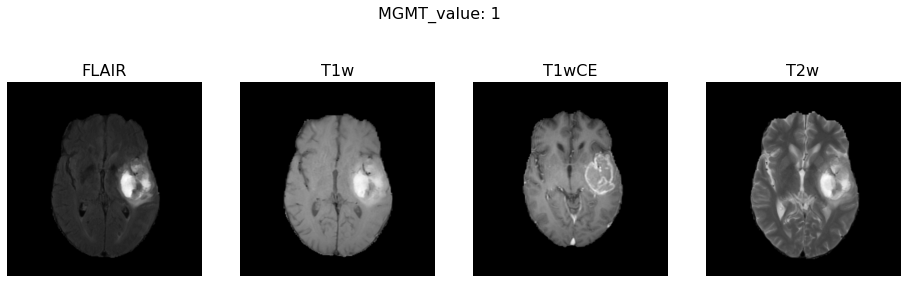

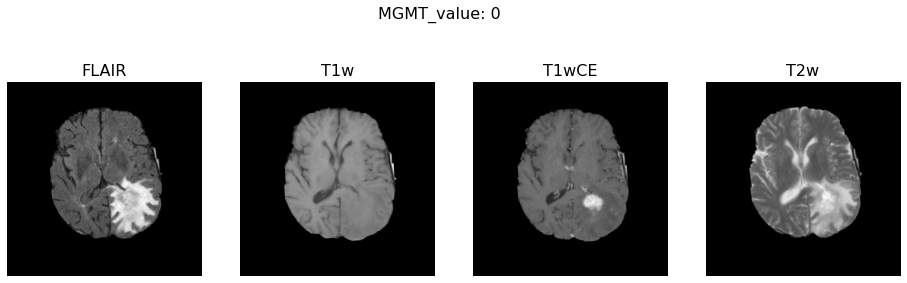

In [14]:
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random  # Import the random module

# Function created to load DICOM files
def load_dicom_file(path):
    dicom_file = pydicom.read_file(path)
    pixel_array = dicom_file.pixel_array
    pixel_array = pixel_array - np.min(pixel_array)
    if np.max(pixel_array) != 0:
        pixel_array = pixel_array / np.max(pixel_array)
    pixel_array = (pixel_array * 255).astype(np.uint8)
    return pixel_array

# Function created to visualize a sample of brain tumor radiogenomic data
def visualize_sample(brats21id, slice_i, mgmt_value, types=("FLAIR", "T1w", "T1wCE", "T2w")):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        pixel_array = load_dicom_file(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(pixel_array, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

# Selecting a random sample of 10 brain tumor radiogenomic images from the training dataset
random_indices = random.sample(range(train_df.shape[0]), 10)

# Visualizing each sample using the `visualize_sample()` function
for i in random_indices:
    brats21id = train_df.iloc[i]["BraTS21ID"]
    mgmt_value = train_df.iloc[i]["MGMT_value"]
    visualize_sample(brats21id=brats21id, mgmt_value=mgmt_value, slice_i=0.5)


# 4. Building a Convolutional Neural Network (CNN) Model
Definition: CNNs are well-suited for image classification. They extract features from images through convolutional layers, pooling layers, and fully connected layers.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

# 5. Model Training
Definition: The model is trained on a dataset to minimize the loss function, which measures the difference between predicted and actual labels.

In [16]:
import numpy as np

# Prepare sample data (replace these with your actual datasets)
X_train = np.random.rand(100, 128, 128, 1)  # 100 training samples, shape (128, 128, 1)
y_train = np.random.randint(0, 2, size=(100,))  # 100 binary labels for training data

X_val = np.random.rand(20, 128, 128, 1)  # 20 validation samples, shape (128, 128, 1)
y_val = np.random.randint(0, 2, size=(20,))  # 20 binary labels for validation data

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Print training history to observe loss and accuracy per epoch
print("Training history:", history.history)

# Optionally, you can also evaluate the model on a test set
X_test = np.random.rand(20, 128, 128, 1)  # 20 test samples
y_test = np.random.randint(0, 2, size=(20,))  # 20 binary labels for test data

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



Epoch 1/10
4/4 [==============================] - 2s 469ms/step - loss: 2.6020 - accuracy: 0.4875 - val_loss: 1.2827 - val_accuracy: 0.5500
Epoch 2/10
4/4 [==============================] - 1s 282ms/step - loss: 1.1262 - accuracy: 0.5092 - val_loss: 0.6874 - val_accuracy: 0.5500
Epoch 3/10
4/4 [==============================] - 1s 273ms/step - loss: 0.7025 - accuracy: 0.5224 - val_loss: 0.6934 - val_accuracy: 0.4500
Epoch 4/10
4/4 [==============================] - 1s 281ms/step - loss: 0.7001 - accuracy: 0.4825 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 1s 281ms/step - loss: 0.6997 - accuracy: 0.4929 - val_loss: 0.7005 - val_accuracy: 0.4500
Epoch 6/10
4/4 [==============================] - 1s 274ms/step - loss: 0.6942 - accuracy: 0.5249 - val_loss: 0.6941 - val_accuracy: 0.4500
Epoch 7/10
4/4 [==============================] - 1s 268ms/step - loss: 0.6850 - accuracy: 0.6725 - val_loss: 0.6883 - val_accuracy: 0.5500
Epoch 8/10
4/4 [====

In [17]:
import matplotlib.pyplot as plt

# Assuming you've trained the model and stored the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
4/4 [==============================] - 1s 287ms/step - loss: 0.6632 - accuracy: 0.5700 - val_loss: 0.6897 - val_accuracy: 0.5500
Epoch 2/10
4/4 [==============================] - 1s 272ms/step - loss: 0.6575 - accuracy: 0.5800 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 1s 280ms/step - loss: 0.6420 - accuracy: 0.6900 - val_loss: 0.6895 - val_accuracy: 0.5500
Epoch 4/10
4/4 [==============================] - 1s 276ms/step - loss: 0.6380 - accuracy: 0.6500 - val_loss: 0.6904 - val_accuracy: 0.5500
Epoch 5/10
4/4 [==============================] - 1s 266ms/step - loss: 0.6432 - accuracy: 0.7000 - val_loss: 0.6919 - val_accuracy: 0.5500
Epoch 6/10
4/4 [==============================] - 1s 264ms/step - loss: 0.6307 - accuracy: 0.7600 - val_loss: 0.6902 - val_accuracy: 0.5500
Epoch 7/10
4/4 [==============================] - 1s 265ms/step - loss: 0.6278 - accuracy: 0.6700 - val_loss: 0.6924 - val_accuracy: 0.5500
Epoch 8/10
4/4 [====

#  Plot Training and Validation Loss
You can visualize the training and validation loss over epochs:

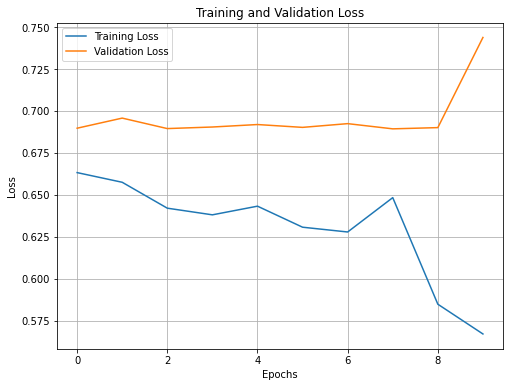

In [18]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Plot Training and Validation Accuracy
Similarly, you can plot the accuracy for both training and validation:

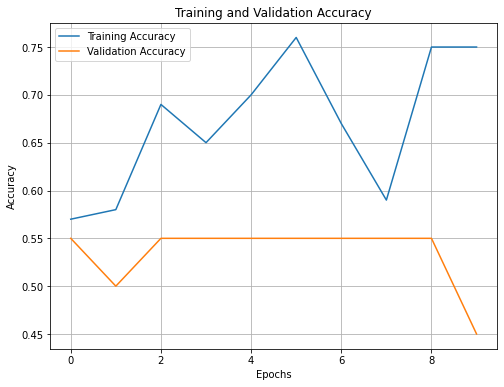

In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# 8. Model Evaluation
Definition: After training, evaluate the model using metrics like accuracy, AUC, precision, and recall on test data.

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

# Predictions on validation/test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy}')
print(f'AUC: {auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


Accuracy: 0.35
AUC: 0.6043956043956044
Precision: 0.35
Recall: 1.0
